Files in Directory 1: ['la_003.nii.gz', 'la_004.nii.gz', 'la_005.nii.gz', 'la_007.nii.gz', 'la_009.nii.gz', 'la_010.nii.gz', 'la_011.nii.gz', 'la_014.nii.gz', 'la_016.nii.gz', 'la_017.nii.gz', 'la_018.nii.gz', 'la_019.nii.gz', 'la_020.nii.gz', 'la_021.nii.gz', 'la_022.nii.gz', 'la_023.nii.gz', 'la_024.nii.gz', 'la_026.nii.gz', 'la_029.nii.gz', 'la_030.nii.gz']
Files in Directory 2: ['la_003.nii.gz', 'la_004.nii.gz', 'la_005.nii.gz', 'la_007.nii.gz', 'la_009.nii.gz', 'la_010.nii.gz', 'la_011.nii.gz', 'la_014.nii.gz', 'la_016.nii.gz', 'la_017.nii.gz', 'la_018.nii.gz', 'la_019.nii.gz', 'la_020.nii.gz', 'la_021.nii.gz', 'la_022.nii.gz', 'la_023.nii.gz', 'la_024.nii.gz', 'la_026.nii.gz', 'la_029.nii.gz', 'la_030.nii.gz']


/home/sua.lim/work/ncdl/NCDL/ncdl/nn/functional/convolution.py:79: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return convolution[_lattice.dimension](data, weights, padding=0, groups=groups)
/home/sua.lim/.local/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/50, Train Loss: 0.9313291957199836, Validation Loss: 0.8661046062197004
Epoch 2/50, Train Loss: 0.9009601129834347, Validation Loss: 0.863579175891457
Epoch 3/50, Train Loss: 0.8660212287818808, Validation Loss: 0.9280289800612481
Epoch 4/50, Train Loss: 0.8496941952978462, Validation Loss: 0.8377099058130285
Epoch 5/50, Train Loss: 0.814072272063352, Validation Loss: 0.7809594185797722
Epoch 6/50, Train Loss: 0.7923487634910886, Validation Loss: 0.7707278429806887
Epoch 7/50, Train Loss: 0.7684759122159512, Validation Loss: 0.7495289815651192
Epoch 8/50, Train Loss: 0.7547029293581252, Validation Loss: 0.8282680825872736
Epoch 9/50, Train Loss: 0.7477506582957533, Validation Loss: 0.7366513193308653
Epoch 10/50, Train Loss: 0.7349407793666822, Validation Loss: 0.7456355694886092
Epoch 11/50, Train Loss: 0.7264224532417264, Validation Loss: 0.734009252013741
Epoch 12/50, Train Loss: 0.724788852200109, Validation Loss: 0.777071781210847
Epoch 13/50, Train Loss: 0.716483127703225

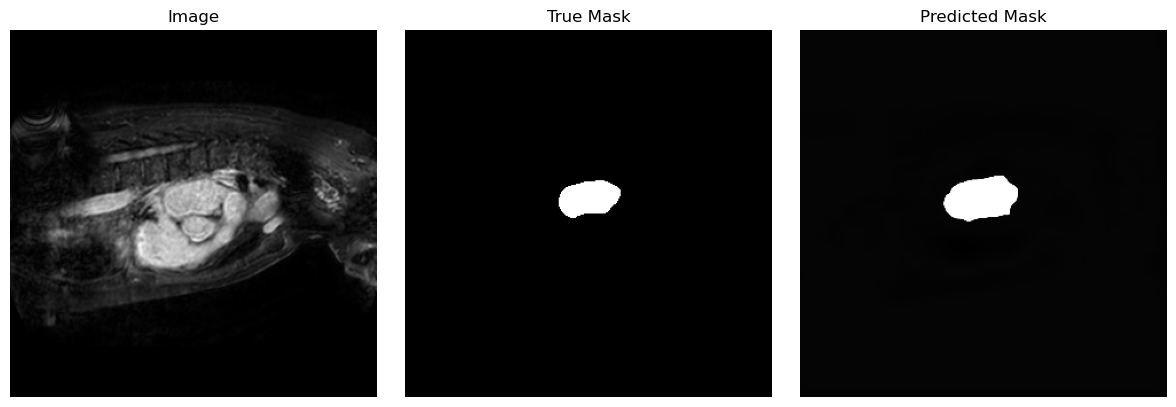

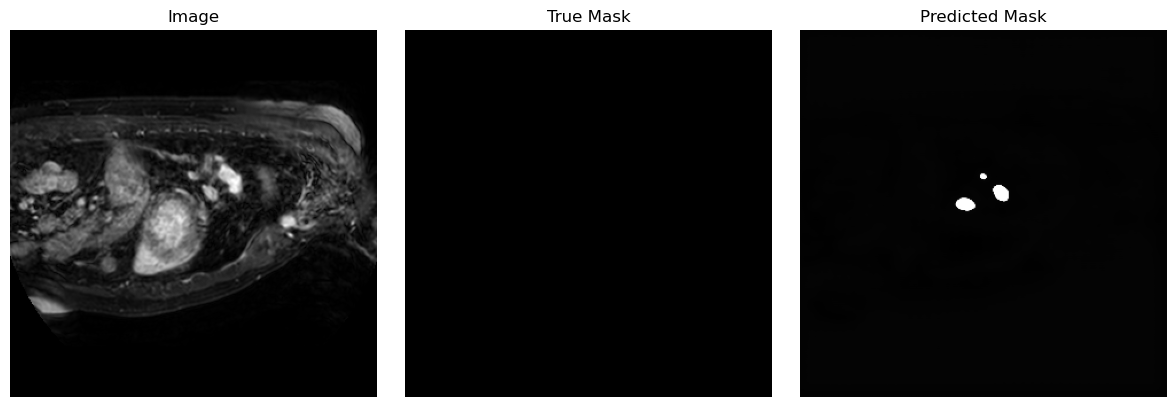

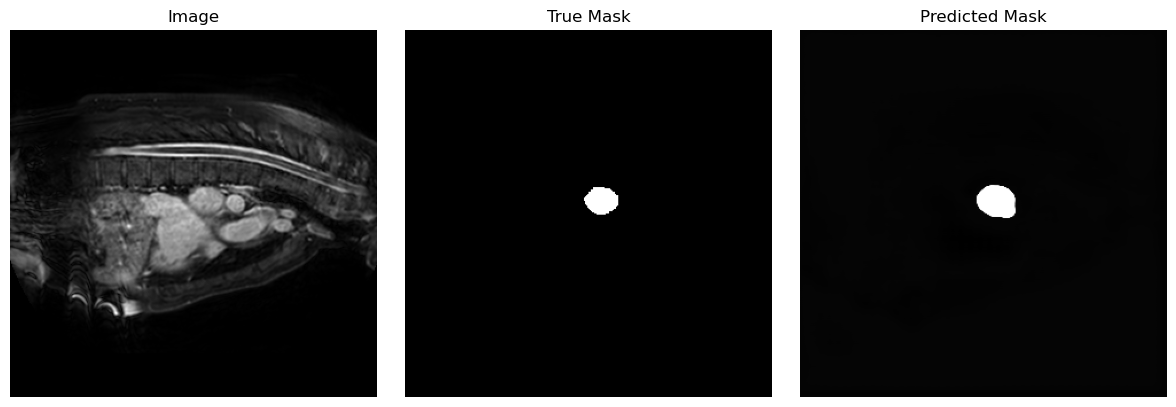

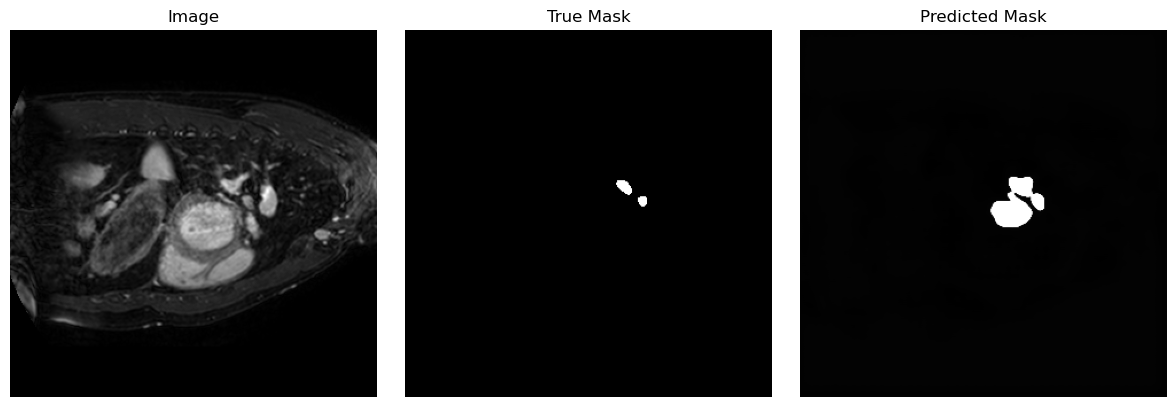

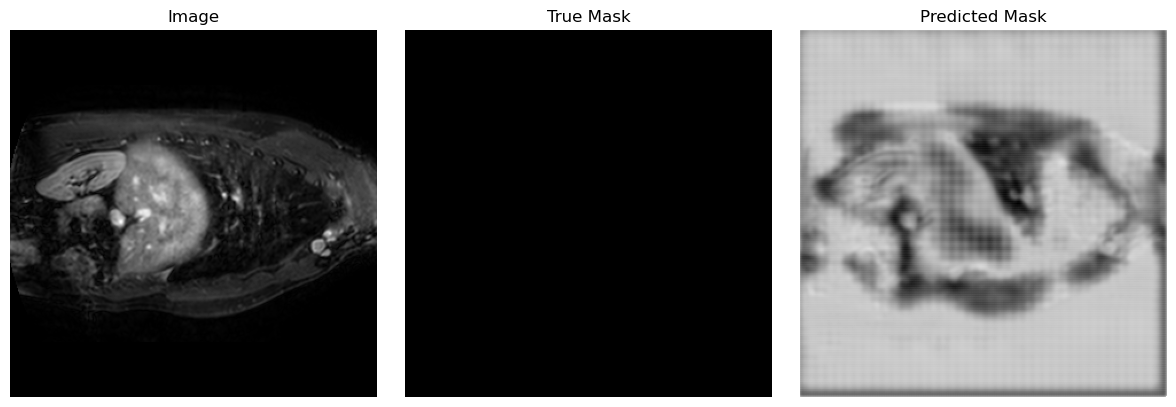

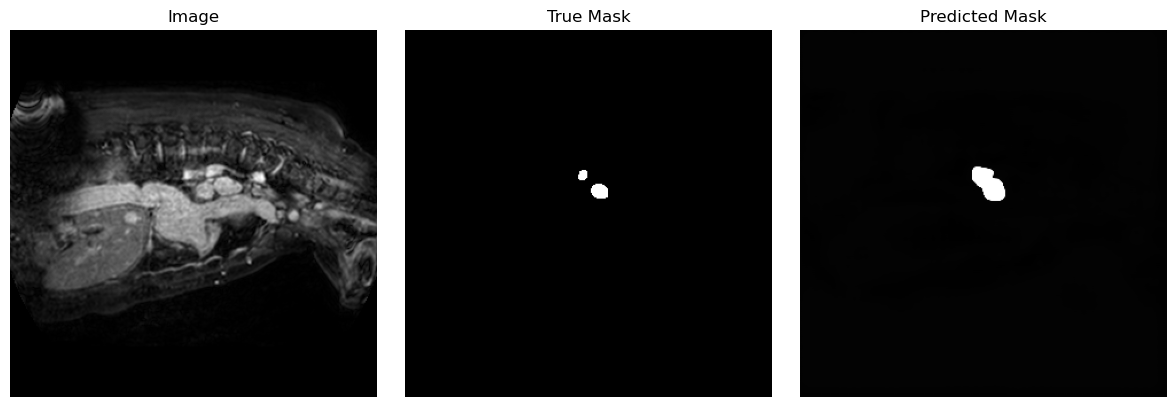

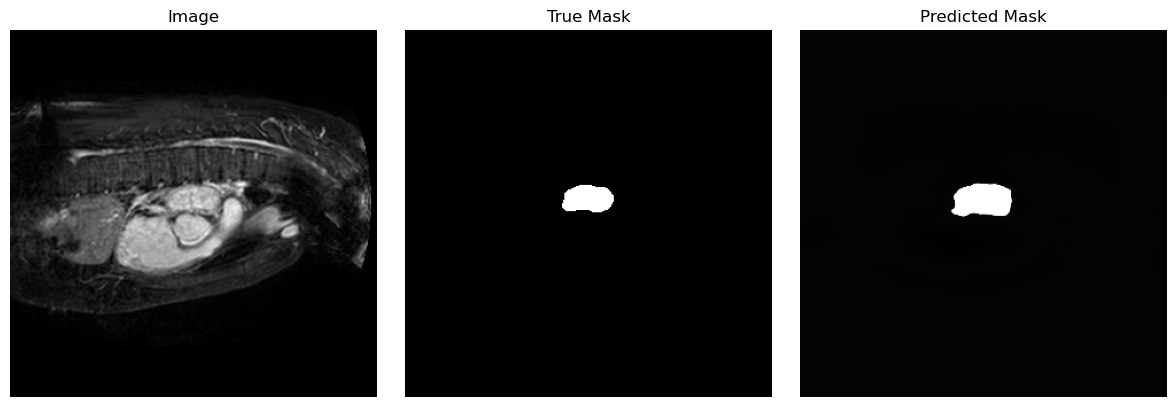

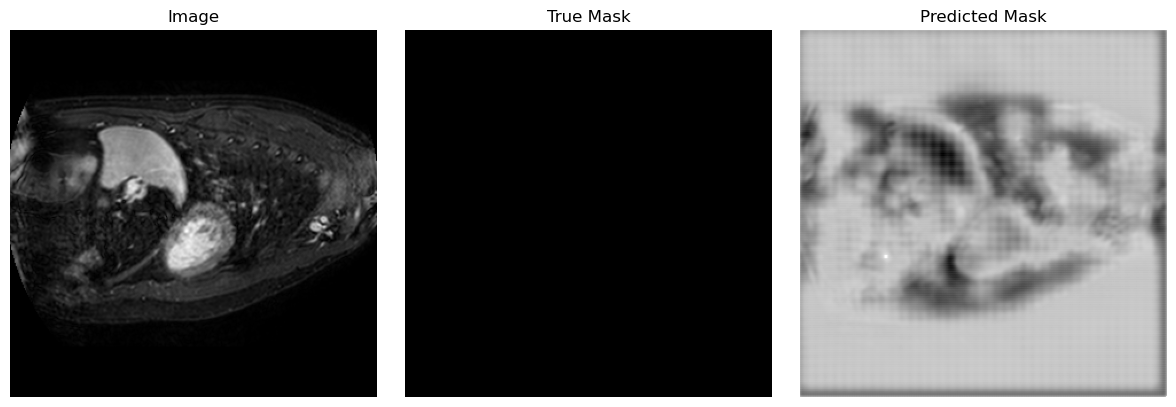

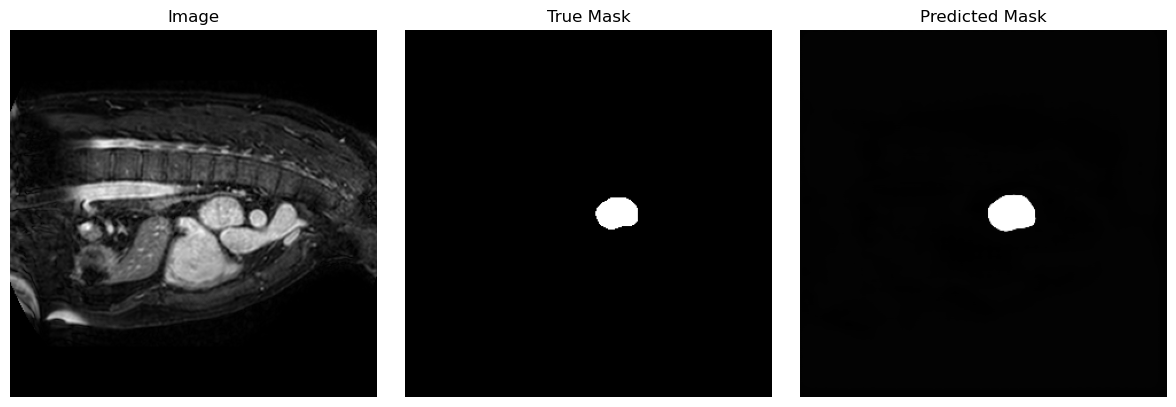

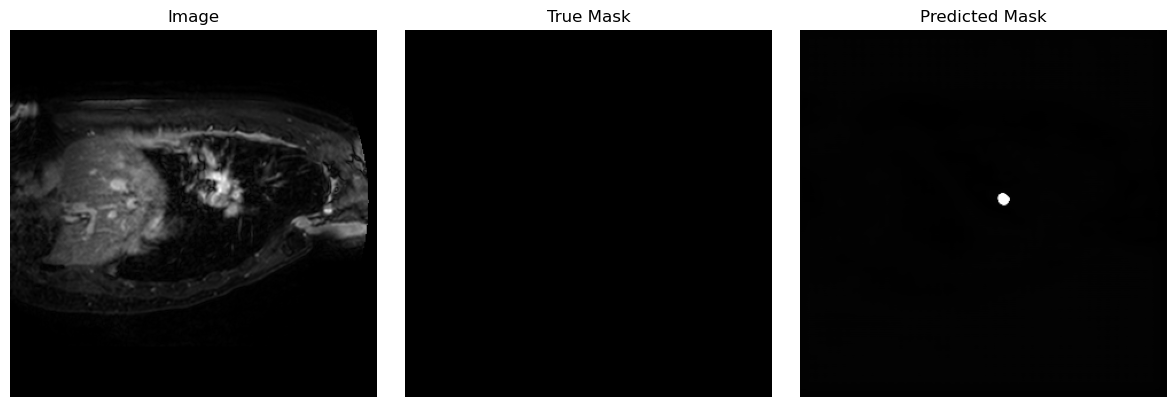

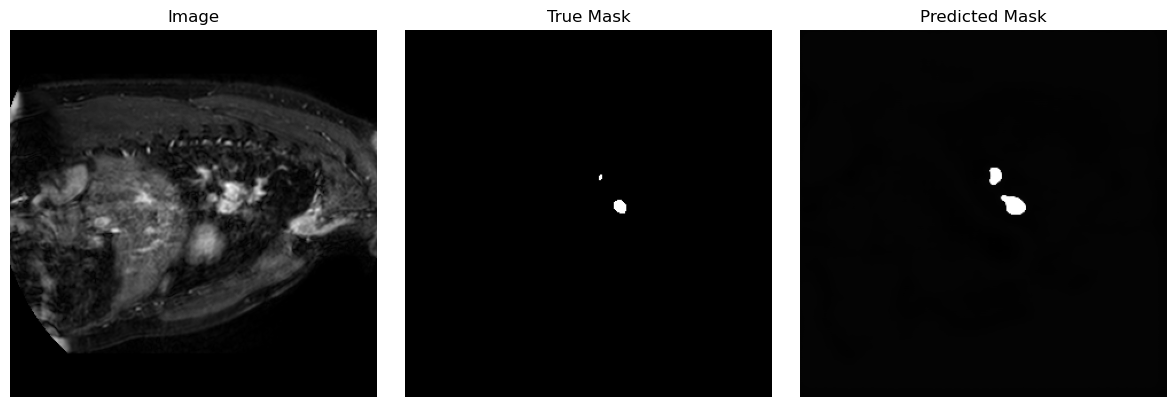

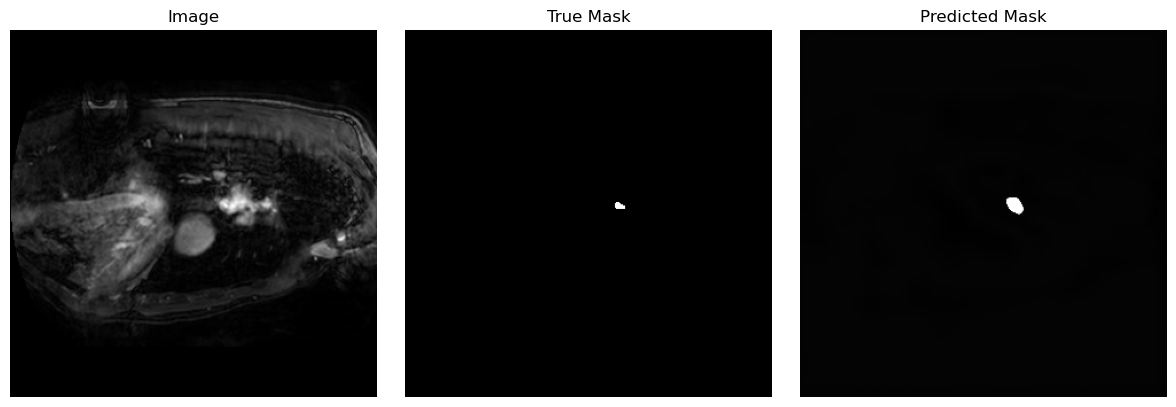

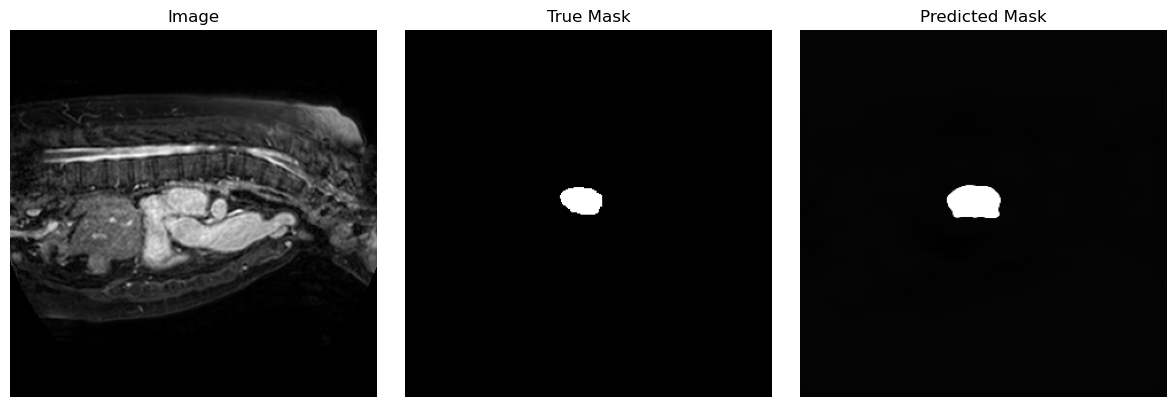

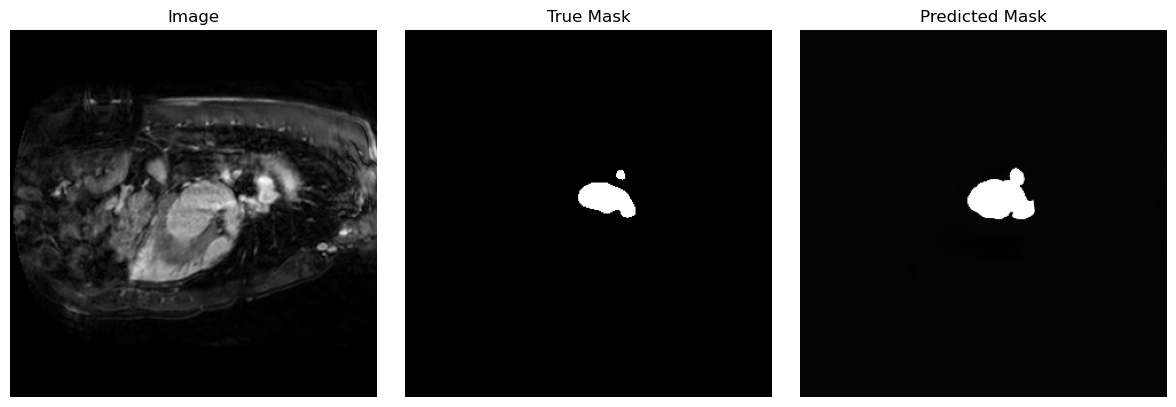

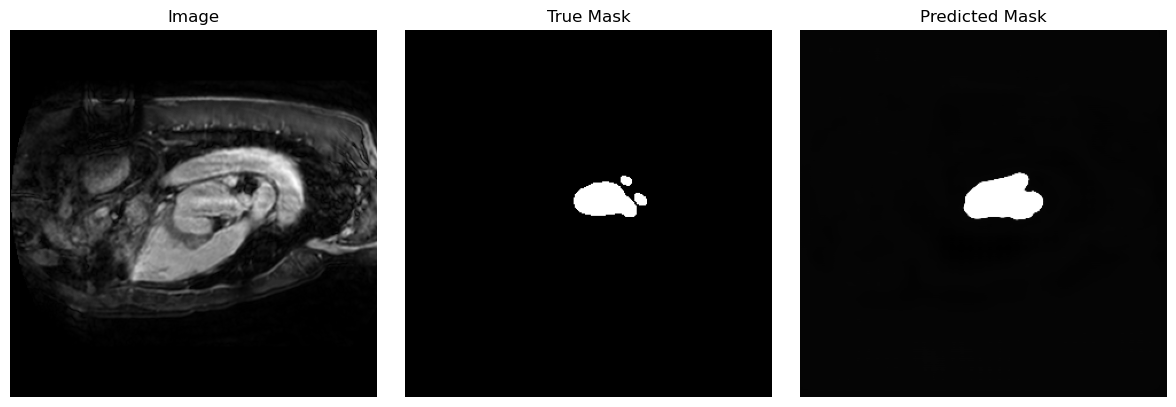

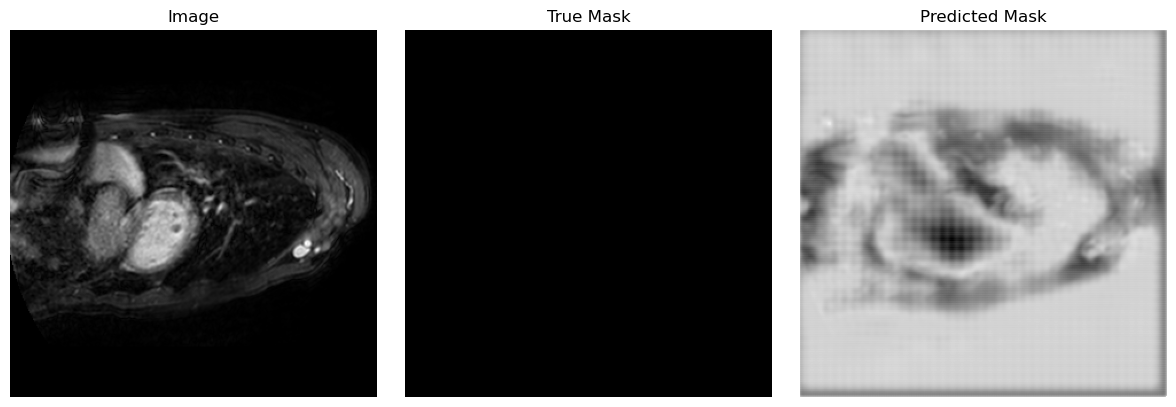

Epoch 50/50, Train Loss: 0.6352769199446959, Validation Loss: 0.6353920155829126


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import ncdl
import ncdl.nn as ncnn
from PIL import Image
from typing import Optional, Callable
from ncdl.nn.functional.downsample import downsample
from ncdl.nn.functional.upsample import upsample
from ncdl import pad_like
from utility import visualize_lattice
from torchsummary import summary
import os
import nibabel as nib
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

image_dir = '/path/to/the/data'
label_dir = '/path/to/the/data'

def list_files(dir, ext):
    return [f for f in os.listdir(dir) if f.endswith(ext) and not f.startswith('._')]

def compare_file_lists(dir1, dir2, ext):
    files1 = sorted(list_files(dir1, ext))
    files2 = sorted(list_files(dir2, ext))
    
    print("Files in Directory 1:", files1)
    print("Files in Directory 2:", files2)
    
    missing_in_dir2 = [f for f in files1 if f not in files2]
    missing_in_dir1 = [f for f in files2 if f not in files1]
    
    if missing_in_dir2:
        print("Missing in second directory:", missing_in_dir2)
    if missing_in_dir1:
        print("Missing in first directory:", missing_in_dir1)
    
    return files1, files2

image_files, label_files = compare_file_lists(image_dir, label_dir, '.nii.gz')

assert sorted(image_files) == sorted(label_files), "Image and label files do not match!"

def load_nii_data(file_path):
    img = nib.load(file_path)
    return img.get_fdata()

def extract_slices(data):
    x, y, z = data.shape
    return [data[:, :, i] for i in range(z)]

def normalize_data(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (data - min_val) / (max_val - min_val)

def load_data(image_files, label_files):
    images = []
    labels = []
    for img_file, lbl_file in zip(image_files, label_files):
        img_path = os.path.join(image_dir, img_file)
        lbl_path = os.path.join(label_dir, lbl_file)
        
        img_data = load_nii_data(img_path)
        lbl_data = load_nii_data(lbl_path)
        
        img_data_normalized = normalize_data(img_data)
        img_slices = extract_slices(img_data_normalized)
        lbl_slices = extract_slices(lbl_data)
        
        images.extend(img_slices)
        labels.extend(lbl_slices)
    
    return images, labels

images, labels = load_data(image_files, label_files)

images = np.expand_dims(np.array(images), axis=1)  
labels = np.expand_dims(np.array(labels), axis=1) 

train_slices, val_slices, train_labels, val_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42
)

class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return torch.tensor(image, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

train_dataset = CustomDataset(train_slices, train_labels)
val_dataset = CustomDataset(val_slices, val_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# LatticeNormalizationWrapper class is from the following:
'''Horacsek, J. (2023). *Non-Cartesian Deep Learning (NCDL)* [Source code]. GitHub. 
   https://github.com/jjh13/NCDL/tree/master/ncdl'''
class LatticeNormalizationWrapper(nn.Module):
    def __init__(self, lattice, channels, normalization):
        super(LatticeNormalizationWrapper, self).__init__()
        assert normalization in [None, 'bn', 'gn', 'in']
        if normalization is None:
            self.module = nn.Identity()
        elif normalization == 'bn':
            self.module = ncnn.LatticeBatchNorm(lattice, channels)
        elif normalization == 'in':
            self.module = ncnn.LatticeInstanceNorm(lattice, channels)
        elif normalization == 'gn':
            group_size = [group_size for group_size in [8,4,2,1] if channels % group_size == 0][0]
            self.module = ncnn.LatticeGroupNorm(lattice, channels//group_size, channels)

    def forward(self, x):
        return self.module(x)

    
class NCDL(nn.Module):
    def __init__(self, lattice: ncdl.Lattice, num_classes=10):
        super().__init__()
        
        self.lattice = lattice

        if lattice == ncdl.Lattice("qc"):
            stencil = ncdl.Stencil([
                (1, 1), (2, 2), (3, 1), (1, 3), (3, 3), (0, 2), (2, 0), (2, 4), (4, 2)

            ], lattice, center=(2, 2))
            
        # encoder
        self.layer2 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout())
        self.layer3 = nn.Sequential(
            ncnn.LatticePad(lattice, stencil),
            ncnn.LatticeConvolution(lattice, channels_in=64, channels_out=128, stencil=stencil, bias=False),
            LatticeNormalizationWrapper(lattice, 128, 'bn'),
            ncnn.LeakyReLU())
        self.layer6 = nn.Sequential(
            ncnn.LatticeUnwrap(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout())
        self.layer7 = nn.Sequential(
            ncnn.LatticePad(lattice, stencil),
            ncnn.LatticeConvolution(lattice, channels_in=256, channels_out=512, stencil=stencil, bias=False),
            LatticeNormalizationWrapper(lattice, 512, 'bn'),
            ncnn.LeakyReLU())
        self.layer10 = nn.Sequential(
            ncnn.LatticeUnwrap(),
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout())
        
        # bottleneck
        self.layer11 = nn.Sequential(
            nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(),
            nn.Dropout())
        self.layer12 = nn.Sequential(
            nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(),
            nn.Dropout())
        
        # decoder
        self.layer20 = nn.Sequential(
            ncnn.LatticeConvolution(lattice, channels_in=1024, channels_out=512, stencil=stencil, bias=False),
            LatticeNormalizationWrapper(lattice, 512, 'bn'),
            ncnn.LeakyReLU())
        self.layer21 = nn.Sequential(
            ncnn.LatticeUnwrap(),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=0, output_padding=1))
        self.layer21sub = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Dropout())
        self.layer24 = nn.Sequential(
            ncnn.LatticeConvolution(lattice, channels_in=256, channels_out=128, stencil=stencil, bias=False),
            LatticeNormalizationWrapper(lattice, 128, 'bn'),
            ncnn.LeakyReLU())     
        self.layer25 = nn.Sequential(
            ncnn.LatticeUnwrap(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=0, output_padding=1))
        self.layer25sub = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout())
        self.layer26 = nn.Sequential(
            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=2, padding=0, output_padding=1),  
            nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1),
            nn.LeakyReLU(),
            nn.Dropout())
        
        self.layer27 = nn.Sequential(
            nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(1),
            nn.LeakyReLU(),
            nn.Sigmoid())
        
    def forward(self, x):
        # downsample
        layer = ncnn.LatticeWrap()
        out4 = self.layer2(x)
        out = layer(out4)
        restore1 = downsample(out, np.array([[-1, 1], [1, 1]], dtype='int'))
        out3 = self.layer3(restore1)
        out2 = self.layer6(out3)
        out = layer(out2)
        restore3 = downsample(out, np.array([[-1, 1], [1, 1]], dtype='int'))
        out1 = self.layer7(restore3)
        out = self.layer10(out1)
        restore4 = layer(out)
        restore4 = downsample(restore4, np.array([[-1, 1], [1, 1]], dtype='int'))

        # bottleneck
        out = self.layer11(out)
        out = self.layer12(out)

        # upsample
        out = layer(out)
        out = upsample(out, np.array([[-1, 1], [1, 1]], dtype='int'))
        out = pad_like(out, restore4)
        out = self.layer20(out)
        out = self.layer21(out)
        out = nn.functional.interpolate(out, size=(40, 40), mode='bilinear', align_corners=False)
        out = torch.cat([out, out2], dim=1)
        out = self.layer21sub(out)
        out = layer(out)
        out = upsample(out, np.array([[-1, 1], [1, 1]], dtype='int'))
        out = pad_like(out, restore3)
        out = self.layer24(out)
        out = self.layer25(out)
        out = nn.functional.interpolate(out, size=(160, 160), mode='bilinear', align_corners=False)
        out = torch.cat([out, out4], dim=1)
        out = self.layer25sub(out)
        out = self.layer26(out)
        out = self.layer27(out)
        return out

def save_and_show_images(images, true_masks, predicted_masks, epoch):
    for i in range(len(images)):
        image = images[i].cpu().numpy().squeeze()
        true_mask = true_masks[i].cpu().numpy().squeeze()
        predicted_mask = predicted_masks[i].cpu().numpy().squeeze()

        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 3, 1)
        plt.title('Image')
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.title('True Mask')
        plt.imshow(true_mask, cmap='gray')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.title('Predicted Mask')
        plt.imshow(predicted_mask, cmap='gray')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
class IoULossGradient(nn.Module):
    def __init__(self, smooth=1e-6):
        super(IoULossGradient, self).__init__()
        self.smooth = smooth
    
    def forward(self, outputs, targets):
        outputs = outputs.view(-1)         
        targets = targets.view(-1)
        
        intersection = torch.sum(outputs * targets)             
        union = torch.sum(outputs) + torch.sum(targets)        
        
        score = (intersection + self.smooth) / (union + self.smooth)     
        
        loss = 1. - score                             
        return loss

class IoULoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(IoULoss, self).__init__()
        self.smooth = smooth

    def forward(self, outputs, targets):
        outputs = (outputs > 0.5).float()

        intersection = torch.sum(outputs * targets)
        union = torch.sum(outputs) + torch.sum(targets)

        score = (intersection + self.smooth) / (union + self.smooth)
        loss = 1. - score

        return loss

lattice = ncdl.Lattice("qc")
model = NCDL(lattice)

criterion = IoULossGradient()
lossValue = IoULoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        train_loss += lossValue(outputs, masks).item() * images.size(0)

    train_loss /= len(train_loader.dataset)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, (images, masks) in enumerate(val_loader):
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += lossValue(outputs, masks).item() * images.size(0)

            if epoch == num_epochs - 1 and i == 0:  
                save_and_show_images(images, masks, outputs, epoch)

    val_loss /= len(val_loader.dataset)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}")
    
